In [7]:
import pandas as pd
import numpy as np
from deepblast.trainer import LightningAligner
import matplotlib.pyplot as plt
import seaborn as sns
from deepblast.dataset.utils import states2edges
from deepblast.score import alignment_score
%matplotlib inline

In [8]:
!ls -lhrt ../lightning_logs/version_174156/checkpoints

total 590M
-rw-r--r-- 1 juermieboop juermieboop 590M Aug 18 12:15 'epoch=6.ckpt'


TODO: Have the pretrained model be downloadable

TODO: Have the malisam and malidup datasets downloadable as well

In [9]:
#ckpt_path = '../../deep_blast_training/lightning_logs/version_174156/checkpoints/epoch=6.ckpt'
ckpt_path = '../../deep_blast_training/lightning_logs/version_174137/checkpoints/epoch=9.ckpt'

model = LightningAligner.load_from_checkpoint(ckpt_path).cuda()

In [10]:
from deepblast.dataset.parse_mali import read_mali, read_mali_mammoth

import seaborn as sns
from deepblast.dataset.utils import states2matrix
from deepblast.dataset.utils import state_f, tmstate_f, revstate_f
from deepblast.score import alignment_score_kernel

In [11]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.SubsMat import MatrixInfo as matlist
from deepblast.dataset.utils import state_f
matrix = matlist.blosum62
def nw_f(x, y):
    alignments = pairwise2.align.globaldx(x, y, matrix)
    states = list(map(state_f, zip(list(alignments[0].seqA), list(alignments[0].seqB))))
    states = ''.join(list(map(revstate_f, states)))
    return states

In [12]:
malidup_root = '../data/structure_benchmarks/malidup'
malisam_root = '../data/structure_benchmarks/malisam'

mammoth_dup_root = '../data/structure_benchmarks/mammoth/malidup'
mammoth_sam_root = '../data/structure_benchmarks/mammoth/malisam'

mali_root = malisam_root
mali_mammoth = mammoth_sam_root
benchmark = 'malisam'

# Malidup / Malisam benchmark

In [13]:
# read in manual and Mammoth
mammoth = read_mali_mammoth(mali_mammoth, report_ids=True)
manual = read_mali(mali_root, tool='manual', report_ids=True)
res = pd.merge(manual, mammoth, left_on='dir', right_on='pdb')
res = res[['0_x', '1_x', '2_x', '2_y']]
res = res.rename(columns={'0_x' : 0, '1_x' : 1, '2_x' : 'manual', '2_y': 'mammoth'})
res = res[~res.set_index([0, 1]).index.duplicated(keep='first')]
res = res.set_index([0, 1])

# read in TMalign, Fast and Dali 
fast   = read_mali(mali_root, tool='fast')
tm     = read_mali(mali_root, tool='tm')
dali   = read_mali(mali_root, tool='dali')
fast = fast[~fast.set_index([0, 1]).index.duplicated(keep='first')]
tm = tm[~tm.set_index([0, 1]).index.duplicated(keep='first')]
dali = dali[~dali.set_index([0, 1]).index.duplicated(keep='first')]

# build multi-indexes
tm_ = tm.set_index([0, 1]).rename(columns={2: 'tm'})
fast_ = fast.set_index([0, 1]).rename(columns={2: 'fast'})
dali_ = dali.set_index([0, 1]).rename(columns={2: 'dali'})

# merge together
res = pd.merge(res, fast_, left_index=True, right_index=True)
res = pd.merge(res, tm_, left_index=True, right_index=True)
res = pd.merge(res, dali_, left_index=True, right_index=True)
#res = rename ['fast', 'tm', 'dali']

# Needleman-wunsch and deepblast
nw     = res.reset_index().apply(lambda x: nw_f(x[1], x[0]), axis=1)
dp     = res.reset_index().apply(lambda x: model.align(x[1], x[0]), axis=1)
res['needleman-wunsch'] = nw.values
res['deepblast'] = dp.values

In [16]:
manual

,,2,query_id,hit_id,pdb,dir
0,1,,,,,
SPYVLPVPFLNVLNGGSHAGGALALQEFMIAPTGAKTFAEALRIGSEVYHNLKSLTKKRYGASAGNVGDEGGVAPNIQ,EEVTIKANLIFANGSTQTAEFKGTFEKATSEAYAYADTLKKDNGEWTVDVADKGYTLNIKFAG,222::::::::::::22222222::::::::::22:::::::::::...,0,130,d2onea1d1hz6b_,d2onea1d1hz6b_
YSNITVERATLPVRAITKTLRDNGIPATISYSAYPLKAGFIHVPYTPDQVVNKFFLLGKNTPSMCLEAEIKAIELAVKVSLDYLEKDRDDIKIPL,MRIEVTIAKTSPLPAGAIDALAGELSRRIQYAFPDNEGHVSVRYAAANNLSVIGATKEDKQRISEILQETWESADDWFVSE,2:::::::111111::::::::::::::::11111111::::::::...,1,131,d1a2za_d1ghha_,d1a2za_d1ghha_
KGGFNSLVLNFVEKEDLSQDEIEELRNILNKKKGGFNSLVLNFVEKEDLSQDEIEELRNILNK,AADVVPATIARFKQLSAEDQLALIWFAYLEMGKTITLSANANAILVTIQGIDPGQQITVLRNCVVDMGFD,::::::::::::::22::::::::::::::::111111::::::::...,2,132,d1okra_d1m98a1,d1okra_d1m98a1
ARPCIPKSFGYSSVVCVCNASPPAQNLLLKSYFSEEGIGYSPIIVDITKDTFYKQP,IPPQILKEGKNAVLSFIAGLFDAEGHVSNKPGIELGMVNKRLIEDVTHYLNALGIKARIREKLRKDGIDYVLHVEEYSSLLRFYELIGKNLQNEEKREKLEKVLSNHKG,111111111111111111111:::::::::2222:::::::11:::...,3,133,d1ogsa2d1dq3a4,d1ogsa2d1dq3a4
GFSLRREPKTVHASGGSAQLGQTVAHDVAQSGRKHLLSLRFANVQGHAIACSCEGSQFKLFDPNLGEFQSSRSAAPQLIKGLIDHYNSLNYDVACVNEFRVSV,NEKLFTAWFSDLTPETLVTRNKAQLKAFWEKHSDIILKPLDGMGGASIFRVKEGDPNLGVIAETLTEHGTRYCMAQNYLPAIKD,11111111::::::::::::2222222::::::::::::2::::::...,4,134,d1ukfa_d1gsa_2,d1ukfa_d1gsa_2
...,...,...,...,...,...,...
LPASIFRAYDIRGVVGDTLTAETAYWIGRAIGSESLARGEGKSGVMLTGSHNPPDYNGFKIVVAGETLANEQIQALRERIEKND,AESSLRVISKEKNSITVEMINYDNTLLRTLVEEILKDDQVDEARYYIKHPVIDNPQIYVRVKSGKPQSAIKRAVRKLSKLYEDLGTQFQKEFQRYESDH,1::::::1::1111:::::::222:::::::::::::::::22222...,125,255,d1p5gx1d1xppa_,d1p5gx1d1xppa_
SENPILDAEAVVLLYECLKELGLRRLKVKLSSVGLGEEARAHLKEVERHLERLSVPYELEPALVRGLDYYVRTAFEVHHEEIGAQSALGGGGRYD,VGVNVMLKLLEKAAKVMGDYTDIEIIEAHHRHKVDAPSGTALAMGEAIAHALDKDLKDCAVYSREGHTGERVPGTIGFATVRAGDIVGEHTAMFADIGERLEITHKASSR,2:::::::::::::::::::2222::::::::::11112:::::::...,126,256,d1adja2d1drw_2,d1adja2d1drw_2
SNITVERATLPVRAITKTLRDNGIPATISYSAYPLKAGFIHVPYTPDQVVNKFFLLGKNTPSMCLEAEIKAIELAVKVSLDYLEKDRDDIKIPLKPEIVINLGLAPTY,MPHLRFRAVEAHIVESLVPTLLNELSSLLSTARNAFTFELINTQYFAEGGVYPMVEVLWFGREQQTQDQIAQVITDQIRQLLGADSHLAVVFIPLQRTAYYLDGQHF,2::::::1111111:::::::::::::::::1111::::::::111...,127,257,d1a2za_d1u9da_,d1a2za_d1u9da_


In [14]:
# Saving the alignment
manual = manual.set_index([0, 1])
pd.merge(manual[['pdb', 'dir']], res, left_index=True, right_index=True).to_csv('malisam_alignments.csv')

Parse BLAST and HMMER

In [ ]:
# Blast and HMMER
from deepblast.dataset.parse_hmmer import get_hmmer_alignments
from deepblast.dataset.parse_blast import get_blast_alignments

hmmer_path = f'../results/hmmer/{benchmark}-hmm.out'
blast_path = f'../results/blast/{benchmark}_blast_alignments.xml'

hmmer_df = get_hmmer_alignments(hmmer_path, mali_root)
blast_df = get_blast_alignments(blast_path, mali_root)

ref = read_mali(mali_root, tool='manual', report_ids=True)
ref = ref.set_index(['query_id', 'hit_id'])

ref_hmmer = pd.merge(ref, hmmer_df.set_index(['query_id', 'hit_id']), 
                     left_index=True, right_index=True, how='left')
ref_hmmer = ref_hmmer.rename(columns={2: 'manual'})
ref_blast = pd.merge(ref, blast_df.set_index(['query_id', 'hit_id']), 
                     left_index=True, right_index=True, how='left')
ref_blast = ref_blast.rename(columns={2: 'manual'})

# clean up types

ref_blast = ref_blast.fillna(-1)
ref_blast['query_start'] = ref_blast['query_start'].astype(np.int64)
ref_blast['hit_start'] = ref_blast['hit_start'].astype(np.int64)

ref_hmmer = ref_hmmer.fillna(-1)
ref_hmmer['query_start'] = ref_hmmer['query_start'].astype(np.int64)
ref_hmmer['hit_start'] = ref_hmmer['hit_start'].astype(np.int64)

Define scoring functions with predefined kernels, and parallelize with Dask.

In [9]:
import dask.dataframe as dd

def score_local_identity(x, k):
    if x['query_start'] < 0 :
        return [0.] * len(k)
    else:
        return alignment_score_kernel(x['manual'], x['aln'], kernel_widths=k, 
                                      query_offset=x['query_start'],
                                      hit_offset=x['hit_start'])

def score_local_alignment(df, k, n_cores=4):
    df2 = dd.from_pandas(df, npartitions=n_cores)
    func = lambda x: score_local_identity(x, k)
    res = df2.apply(func, axis=1)
    resdf = res.compute(scheduler='processes')
    return pd.DataFrame(list(resdf.values), columns=k)

def score_global_alignment(df, col, k, n_cores=4):
    df2 = dd.from_pandas(df, npartitions=n_cores)
    func = lambda x: alignment_score_kernel(x['manual'], x[col], k)
    res = df2.apply(func, axis=1)
    resdf = res.compute(scheduler='processes')
    return pd.DataFrame(list(resdf.values), columns=k)

Obtain local and global alignment stats

In [10]:
import warnings
warnings.filterwarnings("ignore")
k = [1, 3, 5, 10]

# Obtain local alignment stats in parallel
blast_stats = score_local_alignment(ref_blast.reset_index(), k, n_cores=30)
hmmer_stats = score_local_alignment(ref_hmmer.reset_index(), k, n_cores=30)

# Global alignments
fast_stats = score_global_alignment(res.reset_index(), 'fast', k, n_cores=30)
tm_stats = score_global_alignment(res.reset_index(), 'tm', k, n_cores=30)
dali_stats = score_global_alignment(res.reset_index(), 'dali', k, n_cores=30)
deep_stats = score_global_alignment(res.reset_index(), 'deepblast', k, n_cores=30)
nw_stats = score_global_alignment(res.reset_index(), 'needleman-wunsch', k, n_cores=30)

In [11]:
mam_stats = score_global_alignment(res.reset_index(), 'mammoth', k, n_cores=30)

Perform some dataset massaging to plot.

In [12]:
fast_stats['tool'] = 'fast'
tm_stats['tool'] = 'tm'
dali_stats['tool'] = 'dali'
deep_stats['tool'] = 'deepblast'
nw_stats['tool'] = 'nw'
blast_stats['tool'] = 'blast'
hmmer_stats['tool'] = 'hmmer'
mam_stats['tool'] = 'mammoth'


# add additional metadata regarding the pdb files
manual = read_mali(mali_root, tool='manual', report_ids=True)
fast_stats['pdb'] = manual['pdb']
tm_stats['pdb'] = manual['pdb']
dali_stats['pdb'] = manual['pdb']
deep_stats['pdb'] = manual['pdb']
nw_stats['pdb'] = manual['pdb']
blast_stats['pdb'] = manual['pdb']
hmmer_stats['pdb'] = manual['pdb']
mam_stats['pdb'] = manual['pdb']


# combine stats
data = pd.concat((fast_stats, tm_stats, dali_stats, deep_stats, nw_stats, blast_stats, hmmer_stats, mam_stats))

# save file locally for later
data.to_csv(f'{benchmark}_perc_id.csv')

# melt dataframe to make it easier to plot
data = pd.melt(data, id_vars=['tool', 'pdb'], var_name='kernel_width')

Now, let's plot the benchmark results.

In [6]:
# Run if need to regenerate figures from existing data
benchmark = 'malidup'
data = pd.read_csv('malidup_perc_id.csv', index_col=0)
data = pd.melt(data, id_vars=['tool', 'pdb'], var_name='kernel_width')

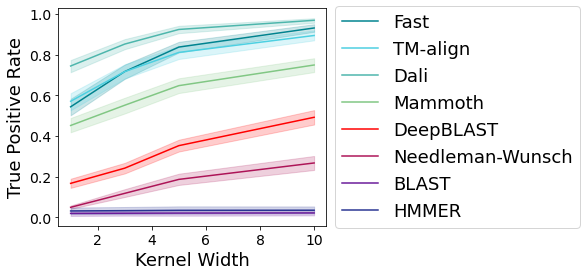

In [13]:
lookup = {'fast' : 'Fast', 'tm' : 'TM-align', 'dali' : 'Dali', 
 'mammoth': 'Mammoth', 'deepblast' : 'DeepBLAST', 
 'nw' : 'Needleman-Wunsch', 'blast' : 'BLAST', 'hmmer' : 'HMMER'}

data['Method'] = data.apply(lambda x: lookup[x['tool']], axis=1)

green = sns.light_palette("seagreen")
purple = sns.dark_palette("blue", reverse=True)
fig, ax = plt.subplots()
palette = {
    'Fast' : '#00838f',
    'TM-align' : '#4dd0e1',
    'Dali' : '#4db6ac',
    'Mammoth' : '#81c784',
    'DeepBLAST': 'r',
    'Needleman-Wunsch' : '#ad1457', 
    'BLAST' : '#6a1b9a',
    'HMMER' : '#283593'
}
sns.lineplot(data=data, x='kernel_width', y='value', hue='Method', ax=ax,
             palette=palette, hue_order=['Fast', 'TM-align', 'Dali', 'Mammoth', 
                                         'DeepBLAST', 'Needleman-Wunsch', 'BLAST', 'HMMER'])

ax.set_ylabel('Percent Identity')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_xlabel('Kernel Width', fontsize=18)
ax.tick_params(labelsize=14)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 18})
fig.savefig(f'{benchmark}.png', bbox_inches='tight')

Other statistics to plot

In [14]:
columns = [
        'val_tp', 'val_fp', 'val_fn', 'val_perc_id',
        'val_ppv', 'val_fnr', 'val_fdr'
]

fast_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['fast']), axis=1).values), 
                          columns=columns)
tm_stats   = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['tm']), axis=1).values), 
                          columns=columns)
dali_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['dali']), axis=1).values), 
                          columns=columns)
mam_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['mammoth']), axis=1).values), 
                          columns=columns)
deep_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['deepblast']), axis=1).values), 
                          columns=columns)
nw_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['needleman-wunsch']), axis=1).values), 
                          columns=columns)

In [15]:
def local_alignment_score(x):
    if x['aln'] == -1:
        n_matches = np.sum(np.array(list(x['manual'])) == ':')
        return 0, np.nan, n_matches, 0, 0, 1, 0
    else:
        return alignment_score(x['manual'], x['aln'])

In [16]:
blast_stats = pd.DataFrame(list(ref_blast.apply(local_alignment_score, axis=1).values), 
                           columns=columns)
hmmer_stats = pd.DataFrame(list(ref_hmmer.apply(local_alignment_score, axis=1).values), 
                           columns=columns)

In [17]:
fast_stats['tool'] = 'fast'
tm_stats['tool'] = 'tm'
dali_stats['tool'] = 'dali'
mam_stats['tool'] = 'mammoth'
deep_stats['tool'] = 'deepblast'
nw_stats['tool'] = 'nw'
blast_stats['tool'] = 'blast'
hmmer_stats['tool'] = 'hmmer'
data = pd.concat((fast_stats, tm_stats, dali_stats, mam_stats, deep_stats, nw_stats, blast_stats, hmmer_stats))
data.to_csv(f'{benchmark}_allstats.csv')

In [14]:
# read in locally to save time
data = pd.read_csv(f'{benchmark}_allstats.csv', index_col=0)

In [16]:
data = data.dropna()
data['precision'] = data.apply(lambda x: x['val_tp'] / (x['val_tp'] + x['val_fp']), axis=1)
data['recall'] = data.apply(lambda x: x['val_tp'] / (x['val_tp'] + x['val_fn']), axis=1)
data['f1'] = data.apply(lambda x: 2 / ((1 / x['precision']) + (1 / x['recall'])), axis=1)

<ipython-input-16-30784335f682>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['precision'] = data.apply(lambda x: x['val_tp'] / (x['val_tp'] + x['val_fp']), axis=1)
<ipython-input-16-30784335f682>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['recall'] = data.apply(lambda x: x['val_tp'] / (x['val_tp'] + x['val_fn']), axis=1)
<ipython-input-16-30784335f682>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [22]:
data

,val_tp,val_fp,val_fn,val_perc_id,val_ppv,val_fnr,val_fdr,tool,precision,recall,f1
0,67,92.0,65,0.507576,0.421384,0.492424,0.578616,fast,0.421384,0.507576,0.460481
1,135,151.0,114,0.542169,0.472028,0.457831,0.527972,fast,0.472028,0.542169,0.504673
2,50,0.0,0,1.000000,1.000000,0.000000,0.000000,fast,1.000000,1.000000,1.000000
3,49,21.0,11,0.816667,0.700000,0.183333,0.300000,fast,0.700000,0.816667,0.753846
4,160,3.0,3,0.981595,0.981595,0.018405,0.018405,fast,0.981595,0.981595,0.981595
...,...,...,...,...,...,...,...,...,...,...,...
236,1,100.0,87,0.011364,0.009901,0.988636,0.990099,hmmer,0.009901,0.011364,0.010582
237,40,61.0,115,0.258065,0.396040,0.741935,0.603960,hmmer,0.396040,0.258065,0.312500
239,1,100.0,274,0.003636,0.009901,0.996364,0.990099,hmmer,0.009901,0.003636,0.005319
241,14,87.0,33,0.297872,0.138614,0.702128,0.861386,hmmer,0.138614,0.297872,0.189189


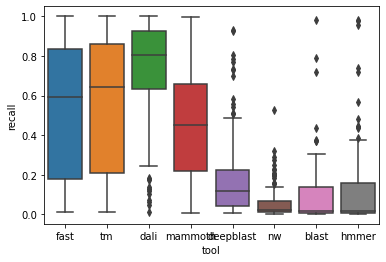

In [24]:
sns.boxplot(data=data, y='recall', x='tool')

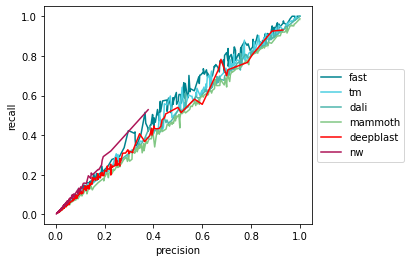

In [19]:
green = sns.light_palette("seagreen")
purple = sns.dark_palette("blue", reverse=True)
fig, ax = plt.subplots()
palette = {
    'fast' : '#00838f',
    'tm' : '#4dd0e1',
    'dali' : '#4db6ac',
    'mammoth' : '#81c784',
    'deepblast': 'r',
    'nw' : '#ad1457', 
    'blast' : '#6a1b9a',
    'hmmer' : '#283593'
}
sns.lineplot(data=data, x='precision', y='recall', hue='tool', ax=ax,
             palette=palette, hue_order=['fast', 'tm', 'dali', 'mammoth', 'deepblast', 'nw'])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(f'{benchmark}_pr_curve.png')

In [20]:
print(data.groupby(['tool']).mean()['f1'].to_latex())

\begin{tabular}{lr}
\toprule
{} &        f1 \\
tool      &           \\
\midrule
blast     &  0.138105 \\
dali      &  0.741813 \\
deepblast &  0.162822 \\
fast      &  0.516061 \\
hmmer     &  0.109583 \\
mammoth   &  0.456971 \\
nw        &  0.042504 \\
tm        &  0.561508 \\
\bottomrule
\end{tabular}



# Other scratch work

In [21]:
columns = [
        'val_tp', 'val_fp', 'val_fn', 'val_perc_id',
        'val_ppv', 'val_fnr', 'val_fdr'
]

fast_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['fast']), axis=1).values), 
                          columns=columns)
tm_stats   = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['tm']), axis=1).values), 
                          columns=columns)
dali_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['dali']), axis=1).values), 
                          columns=columns)
deep_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['deepblast']), axis=1).values), 
                          columns=columns)
nw_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['needleman-wunsch']), axis=1).values), 
                          columns=columns)

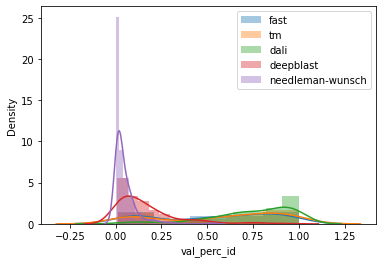

In [22]:

sns.distplot(fast_stats['val_perc_id'], label='fast')
sns.distplot(tm_stats['val_perc_id'], label='tm')
sns.distplot(dali_stats['val_perc_id'], label='dali')
sns.distplot(deep_stats['val_perc_id'], label='deepblast')  # meh
sns.distplot(nw_stats['val_perc_id'], label='needleman-wunsch')  # meh

plt.legend()

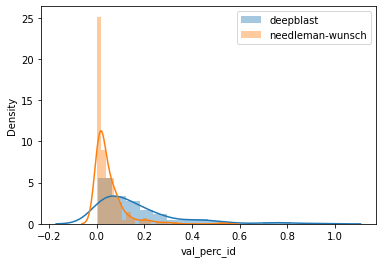

In [23]:
sns.distplot(deep_stats['val_perc_id'], label='deepblast')
sns.distplot(nw_stats['val_perc_id'], label='needleman-wunsch')
plt.legend()

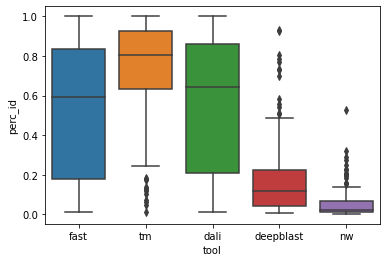

In [24]:
box_df = pd.DataFrame({
    'fast': fast_stats['val_perc_id'],
    'tm': dali_stats['val_perc_id'],
    'dali': tm_stats['val_perc_id'],
    'deepblast': deep_stats['val_perc_id'],
    'nw': nw_stats['val_perc_id']

})
box_df = box_df.melt(var_name='tool', value_name='perc_id')
sns.boxplot(x='tool', y='perc_id', data=box_df)

Percent identity vs kernel

In [25]:
fast_stats['tool'] = 'fast'
tm_stats['tool'] = 'tm'
dali_stats['tool'] = 'dali'
deep_stats['tool'] = 'deepblast'
nw_stats['tool'] = 'nw'
data = pd.concat((fast_stats, tm_stats, dali_stats, deep_stats, nw_stats))

In [26]:
data = pd.melt(data, id_vars=['tool'], var_name='kernel_width')

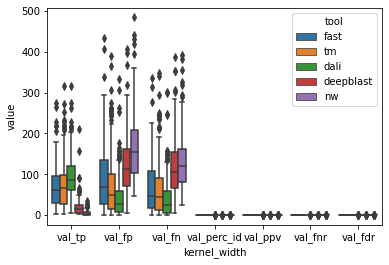

In [27]:
sns.boxplot(data=data, x='kernel_width', y='value', hue='tool') 

In [28]:
data = pd.read_csv('malidup_perc_id.csv')

ValueError: Could not interpret value `kernel_width` for parameter `x`

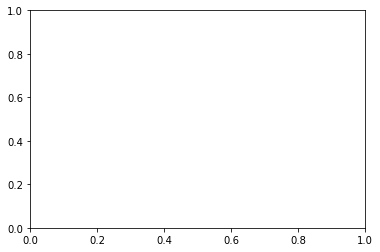

In [29]:
fig, ax = plt.subplots()
sns.lineplot(data=data, x='kernel_width', y='value', hue='tool', ax=ax)

ax.set_ylabel('Percent Identity')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Malisam benchmark

In [ ]:
manual = read_mali(malisam_root, tool='manual')
fast   = read_mali(malisam_root, tool='fast')
tm     = read_mali(malisam_root, tool='tm')
dali   = read_mali(malisam_root, tool='dali')

manual = manual[~manual.set_index([0, 1]).index.duplicated(keep='first')]
fast = fast[~fast.set_index([0, 1]).index.duplicated(keep='first')]
tm = tm[~tm.set_index([0, 1]).index.duplicated(keep='first')]
dali = dali[~dali.set_index([0, 1]).index.duplicated(keep='first')]

# build multi-indexes
manual_ = manual.set_index([0, 1])
tm_ = tm.set_index([0, 1])
fast_ = fast.set_index([0, 1])
dali_ = dali.set_index([0, 1])

# merge together
res = pd.merge(manual_, fast_, left_index=True, right_index=True)
res = pd.merge(res, tm_, left_index=True, right_index=True)
res = pd.merge(res, dali_, left_index=True, right_index=True)
res.columns = ['manual', 'fast', 'tm', 'dali']

In [ ]:
nw     = manual_.loc[res.index].reset_index().apply(lambda x: nw_f(x[1], x[0]), axis=1)
dp     = manual.apply(lambda x: model.align(x[1], x[0])[0], axis=1)

In [ ]:
# build multi-indexes
manual = manual.set_index([0, 1])
tm = tm.set_index([0, 1])
fast = fast.set_index([0, 1])
dali = dali.set_index([0, 1])
tm = tm[~tm.index.duplicated(keep='first')]

# merge together
res = pd.merge(manual, fast, left_index=True, right_index=True)
res = pd.merge(res, tm, left_index=True, right_index=True)
res = pd.merge(res, dali, left_index=True, right_index=True)
res.columns = ['manual', 'fast', 'tm', 'dali']
res = res.dropna()
res['needleman-wunsch'] = nw.values
res['deepblast'] = dp.values

In [ ]:
from deepblast.score import alignment_score
columns = [
        'val_tp', 'val_fp', 'val_fn', 'val_perc_id',
        'val_ppv', 'val_fnr', 'val_fdr'
]
    
fast_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['fast']), axis=1).values), 
                          columns=columns)
tm_stats   = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['tm']), axis=1).values), 
                          columns=columns)
dali_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['dali']), axis=1).values), 
                          columns=columns)
deep_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['deepblast']), axis=1).values), 
                          columns=columns)
nw_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['needleman-wunsch']), axis=1).values), 
                          columns=columns)

In [ ]:
sns.distplot(fast_stats['val_perc_id'], label='fast')
sns.distplot(tm_stats['val_perc_id'], label='tm')
sns.distplot(dali_stats['val_perc_id'], label='dali')
sns.distplot(deep_stats['val_perc_id'], label='deepblast')  # meh
sns.distplot(nw_stats['val_perc_id'], label='needleman-wunsch')  # meh

plt.legend()

In [ ]:
sns.distplot(deep_stats['val_perc_id'], label='deepblast')
sns.distplot(nw_stats['val_perc_id'], label='needleman-wunsch')
plt.legend()

In [ ]:
box_df = pd.DataFrame({
    'fast': fast_stats['val_perc_id'],
    'tm': dali_stats['val_perc_id'],
    'dali': tm_stats['val_perc_id'],
    'deepblast': deep_stats['val_perc_id'],
    'nw': nw_stats['val_perc_id']

})
box_df = box_df.melt(var_name='tool', value_name='perc_id')
sns.boxplot(x='tool', y='perc_id', data=box_df)


In [ ]:
plt.scatter(dali_stats['val_fdr'], dali_stats['val_fnr'], label='dali')
plt.scatter(tm_stats['val_fdr'], tm_stats['val_fnr'], label='tm')
plt.scatter(fast_stats['val_fdr'], fast_stats['val_fnr'], label='fast')
plt.scatter(deep_stats['val_fdr'], deep_stats['val_fnr'], label='deepblast')

plt.legend()

plt.xlabel('FDR')
plt.ylabel('FNR')

# Debugging

In [ ]:
i = 2
x = res.index[i]
pred, A = model.align(x[1], x[0])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

truth = res.iloc[i]['manual']

columns = [
        'val_tp', 'val_fp', 'val_fn', 'val_perc_id',
        'val_ppv', 'val_fnr', 'val_fdr'
]
print(pd.Series(alignment_score(truth, pred), index=columns))

sns.heatmap(states2matrix(list(map(tmstate_f, truth))), ax=ax[0])
sns.heatmap(states2matrix(list(map(tmstate_f, pred))), ax=ax[1])
sns.heatmap(A.cpu().detach().numpy().squeeze(), ax=ax[2], robust=True)

In [ ]:
from deepblast.dataset.utils import states2alignment
a, b = states2alignment(np.array(list(map(tmstate_f, truth))), x[1], x[0])
print('Ground Truth')
print(a)
print(b)
a, b = states2alignment(np.array(list(map(tmstate_f, pred))), x[1], x[0])
print('Prediction')
print(a)
print(b)

In [ ]:
columns = [
        'val_tp', 'val_fp', 'val_fn', 'val_perc_id',
        'val_ppv', 'val_fnr', 'val_fdr'
]

print(pd.Series(alignment_score(truth, pred), index=columns))

In [ ]:
deep_stats

In [ ]:
sns.distplot(deep_stats['val_perc_id'], label='deepblast')
sns.distplot(nw_stats['val_perc_id'], label='needleman-wunsch')
plt.legend()

In [ ]:
sns.distplot(nw_stats['val_perc_id'])

In [ ]:
x

In [ ]:
res